In [1]:
from pathlib import Path
import pickle
import json
import re
import argparse
from tqdm import tqdm
import sys

import numpy as np
import matplotlib.pyplot as plt
from ase.units import create_units

WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

from virialstress import virialvslatconst

%matplotlib inline
plt.style.use("default")

u = create_units("2018")

In [2]:
# Read settings
ROOT_DIR = WORK_DIR.parent
SETTINGS_DIR = ROOT_DIR / "settings"

settings_path = SETTINGS_DIR / "settings0.json"
with open(settings_path, "r") as f:
    settings = json.load(f)

RES_DIR = WORK_DIR / "results" / re.match(r"^[^_\.]+", settings_path.name).group()
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)
PLOT_DIR = RES_DIR / "plots"
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True)

In [3]:
alist = np.linspace(0.95, 1.05, 11) * 2.466

In [4]:
stress_ens = np.zeros((100, len(alist), 6))

for ii in tqdm(range(100)):
    path = RES_DIR / f"{ii:03d}" / "virial_stress_graphene"
    modelname = f"DUNN_bootstrap_{ii:03d}"
    stress_ens[ii] = virialvslatconst(modelname, alist, None, path)

# Convert the stress data unit into GPa
stress_ens = stress_ens * u["bar"] / u["GPa"]

100%|███████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.22it/s]


In [5]:
stress_mean = np.mean(stress_ens, axis=0)
stress_std = np.std(stress_ens, axis=0)

In [6]:
# Export the data needed to plot the result
plot_data_dict = {
    "stress": {"values": stress_ens, "metadata": "Virial stress in GPa"},
    "alist": {"value": alist, "metadata": "List of lattice parameters in angstrom"},
}
with open(RES_DIR / "uncertainty_virial_stress_graphene.pkl", "wb") as f:
    pickle.dump(plot_data_dict, f, protocol=4)

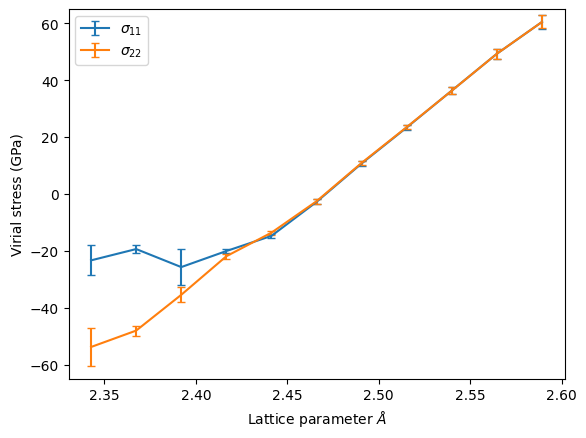

In [7]:
plt.figure()
plt.errorbar(
    alist, -stress_mean[:, 0], stress_std[:, 0], capsize=3, label=r"$\sigma_{11}$"
)
plt.errorbar(
    alist, -stress_mean[:, 1], stress_std[:, 1], capsize=3, label=r"$\sigma_{22}$"
)
plt.xlabel(r"Lattice parameter $\AA$")
plt.ylabel("Virial stress (GPa)")
plt.ylim(-65, 65)
plt.legend()
plt.show()